<h1>Testting Simulation forms to time series</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../data/dadosCovid.csv")
data.head()

,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
0,Norte,RO,2020-01-30,0,0,0,0
1,Norte,RO,2020-01-31,0,0,0,0
2,Norte,RO,2020-02-01,0,0,0,0
3,Norte,RO,2020-02-02,0,0,0,0
4,Norte,RO,2020-02-03,0,0,0,0


In [3]:
#Select only Sao Paulo
sp = data[data["estado"] == "SP"]
#Remove missing values to not crash the intervals
sp = sp.dropna()
sp.head()

,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
1501,Sudeste,SP,2020-02-26,1,1,0,0
1502,Sudeste,SP,2020-02-27,0,1,0,0
1503,Sudeste,SP,2020-02-28,0,1,0,0
1504,Sudeste,SP,2020-02-29,1,2,0,0
1505,Sudeste,SP,2020-03-01,0,2,0,0


In [4]:
#create a series with the cummulative number of cases
y = np.array(sp["casosAcumulados"])

#Give the number of days since the day of first case confirmed
x = range(0,len(sp["casosAcumulados"]))

<h2>Simulating date from a Poisson </h2>
    
<p>Based on <a href="https://www.sciencedirect.com/science/article/pii/S1571064507000413?via%3Dihub"> Chowell and Nishiura (2008)</a> </p>

In [5]:
#simlating from a possion
def bootstratpPoisson(npArray, replicate, cumSum = True):
        simList = []
        def poissonGen(npArray, replicate = None):
            simSeries = []
            for i in range(0,len(npArray)):
                if i == 0:
                    simSeries.append(npArray[i]) 
                else:
                    simSeries.append(np.random.poisson(lam = npArray[i] - npArray[i-1], size = 1)[0])
            if cumSum:
                return np.cumsum(np.array(simSeries))
            else:
                return np.array(simSeries)
        for i in range(0,replicate):
            simList.append(poissonGen(npArray))
        return np.array(simList)

In [6]:
poissSim = bootstratpPoisson(y, 500)

<h2>Simulating from a mixing Poisson</h2>
<p>Based on <a href="http://repositorio.unicamp.br/jspui/bitstream/REPOSIP/305840/1/MercadoLondono_SergioLuis_M.pdf">Londono (2014)</a></p>

In [7]:
#simlating from a duble possion
def bootstrapDPoisson(npArray, replicate):
        simList = []
        poissonsDist = bootstratpPoisson(npArray, replicate, cumSum = False)
        def poissonGen(npArray, replicate = None):
            simSeries = []
            for i in range(0,len(npArray)):
                if i == 0:
                    simSeries.append(npArray[i])
                else:
                    value = np.random.poisson(lam = np.random.choice(poissonsDist[:,i], size = 1), size = 1)[0]
                    #Sanity check
                    if value > 0:
                        simSeries.append(value)
                    else:
                        simSeries.append(np.random.poisson(lam = npArray[i] - npArray[i-1], size = 1)[0])
            return np.cumsum(np.array(simSeries))
        for i in range(0,replicate):
            simList.append(poissonGen(npArray))
        return np.array(simList)

In [8]:
poissSim2 = bootstratpPoisson(y, 500)

<h2>Simulating from a mixing Gamma Poisson</h2>
<p>Based on <a href="http://repositorio.unicamp.br/jspui/bitstream/REPOSIP/305840/1/MercadoLondono_SergioLuis_M.pdf">Londono (2014)</a></p>

In [9]:
#simlating from a miximg poisson gamma
def bootstrapGammaPoisson(npArray, replicate):
    simList = []
    poissonsDist = bootstratpPoisson(npArray, replicate, cumSum = False)
    def poissonGen(npArray, replicate = None):
        simSeries = []
        for i in range(0,len(npArray)):
            if i == 0:
                simSeries.append(npArray[i])
            else:
                meanP = np.mean(poissonsDist[:,i])
                varP = np.var(poissonsDist[:,i])
                if meanP == 0 or varP == 0:
                    value = np.random.poisson(lam = np.random.choice(poissonsDist[:,i], size = 1), size = 1)[0]
                    #Sanity check
                    if value > 0:
                        simSeries.append(value)
                    else:
                        simSeries.append(np.random.poisson(lam = npArray[i] - npArray[i-1], size = 1)[0])
                else:
                    scale = varP/meanP
                    shape = meanP**2/varP
                    mean = np.random.gamma(shape = shape, scale = scale, size = 1)[0]
                    simSeries.append(np.random.poisson(lam = mean, size = 1)[0])
        return np.cumsum(np.array(simSeries))
    for i in range(0,replicate):
        simList.append(poissonGen(npArray))
    return np.array(simList)

In [10]:
poissSim3 = bootstrapGammaPoisson(y, 500)

<p>Inspect the three different approch constructing empirical intervals<p>

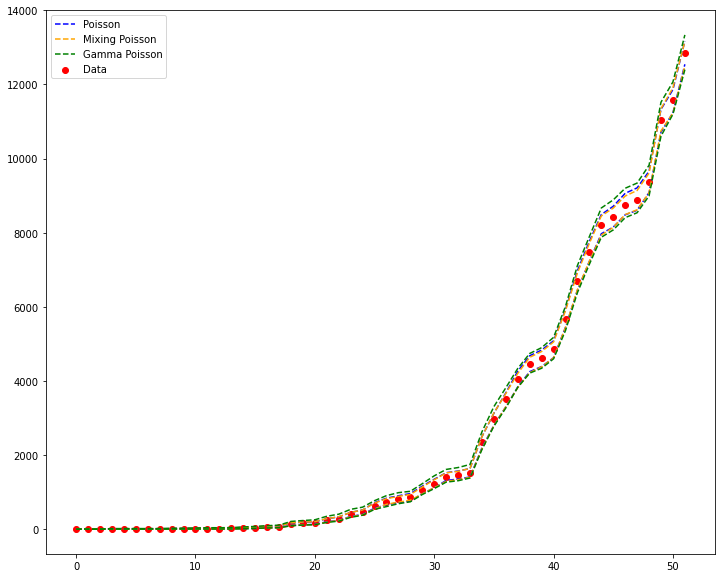

In [11]:
fig, axes = plt.subplots(figsize = (12,10))
axes.scatter(x, y, label = "Data", c = "red")
axes.plot(x, np.quantile(poissSim, q = 0.0, axis = 0), label = "Poisson", ls = "--", c = "blue")
axes.plot(x, np.quantile(poissSim, q = 1, axis = 0), ls = "--", c = "blue")
axes.plot(x, np.quantile(poissSim2, q = 0, axis = 0),label = "Mixing Poisson", ls = "--", c = "orange")
axes.plot(x, np.quantile(poissSim2, q = 1, axis = 0), ls = "--", c = "orange")
axes.plot(x, np.quantile(poissSim3, q = 0, axis = 0), ls = "--", label = "Gamma Poisson", c = "green")
axes.plot(x, np.quantile(poissSim3, q = 1, axis = 0), ls = "--", c = "green")
axes.legend(loc = "upper left")